In [112]:
import spacy
import requests
import pandas as pd
from spacy.lang.en.examples import sentences
from spacy import displacy
import matplotlib.pyplot as plt

In [113]:
# Load the spacy model
nlp = spacy.load('en_core_web_md')

In [114]:
text = "I work as a software engineer for Goldman Sachs in New York City."
displacy.render(nlp(text), style='ent', jupyter=True)

## 1) Anaylzing Positive vs. Negative Features

In [115]:
# read xlsx file as a df
df = pd.read_excel('../data/BookingDotCom_HotelReviews.xlsx')
df.head()

,Hotel_Name,Hotel_Address,Review_Count,Non_Review_Scoring_Count,Average_Hotel_Score,Review_Date,Reviewer_Nationality,Positive_Comments,Negative_Comments,Total_Reviewer_Reviews,Reviewer_Score,Tags
0,Hotel Arena,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,1403,194,7.7,2017-08-03,Russia,Only the park outside of the hotel was beauti...,I am so angry that i made this post available...,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double..."
1,Hotel Arena,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,1403,194,7.7,2017-08-03,Ireland,No real complaints the hotel was great great ...,No Negative,7,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double..."
2,Hotel Arena,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,1403,194,7.7,2017-07-31,Australia,Location was good and staff were ok It is cut...,Rooms are nice but for elderly a bit difficul...,9,7.1,"[' Leisure trip ', ' Family with young childre..."
3,Hotel Arena,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,1403,194,7.7,2017-07-31,United Kingdom,Great location in nice surroundings the bar a...,My room was dirty and I was afraid to walk ba...,1,3.8,"[' Leisure trip ', ' Solo traveler ', ' Duplex..."
4,Hotel Arena,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,1403,194,7.7,2017-07-24,New Zealand,Amazing location and building Romantic setting,You When I booked with your company on line y...,3,6.7,"[' Leisure trip ', ' Couple ', ' Suite ', ' St..."


In [116]:
# normalise the columns, make everything lowercase
df.columns = df.columns.str.lower()
df.columns

Index(['hotel_name', 'hotel_address', 'review_count',
       'non_review_scoring_count', 'average_hotel_score', 'review_date',
       'reviewer_nationality', 'positive_comments', 'negative_comments',
       'total_reviewer_reviews', 'reviewer_score', 'tags'],
      dtype='object')

In [117]:
# make positive_comments column lowercase, same for negative_comments
df['positive_comments'] = df['positive_comments'].str.lower()
df['negative_comments'] = df['negative_comments'].str.lower()
df['tags'] = df['tags'].str.lower()

In [118]:
# make 2 new df's, one for positive reviews and one for negative reviews
df_pos = df[df['reviewer_score'] > 7]
df_neg = df[df['reviewer_score'] < 4]
df_pos.head()

,hotel_name,hotel_address,review_count,non_review_scoring_count,average_hotel_score,review_date,reviewer_nationality,positive_comments,negative_comments,total_reviewer_reviews,reviewer_score,tags
1,Hotel Arena,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,1403,194,7.7,2017-08-03,Ireland,no real complaints the hotel was great great ...,no negative,7,7.5,"[' leisure trip ', ' couple ', ' duplex double..."
2,Hotel Arena,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,1403,194,7.7,2017-07-31,Australia,location was good and staff were ok it is cut...,rooms are nice but for elderly a bit difficul...,9,7.1,"[' leisure trip ', ' family with young childre..."
7,Hotel Arena,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,1403,194,7.7,2017-07-17,United Kingdom,good location set in a lovely park friendly s...,apart from the price for the brekfast everyth...,1,10.0,"[' leisure trip ', ' couple ', ' duplex double..."
9,Hotel Arena,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,1403,194,7.7,2017-07-08,Norway,the room was big enough and the bed is good t...,the aircondition makes so much noise and its ...,1,7.9,"[' leisure trip ', ' couple ', ' large king ro..."
10,Hotel Arena,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,1403,194,7.7,2017-07-07,United Kingdom,rooms were stunningly decorated and really sp...,nothing all great,2,10.0,"[' leisure trip ', ' group ', ' duplex double ..."


In [119]:
print(df_pos.shape, df_neg.shape)

(428476, 12) (10728, 12)


In [120]:
# normalise the tags column by making everything lowercase, the column has a list of strings
df['tags'] = df['tags'].str.lower()
df['tags'].head()

0    [' leisure trip ', ' couple ', ' duplex double...
1    [' leisure trip ', ' couple ', ' duplex double...
2    [' leisure trip ', ' family with young childre...
3    [' leisure trip ', ' solo traveler ', ' duplex...
4    [' leisure trip ', ' couple ', ' suite ', ' st...
Name: tags, dtype: object

In [121]:
# Sample 100 reviews from each df
df_pos_sample = df_pos.sample(n=2500)
df_neg_sample = df_neg.sample(n=2500)

In [122]:
positive_features = dict()
# iterate through the positive reviews and extract the features from column positive_comments
for index, row in df_pos_sample.iterrows():
    positive = row['positive_comments']
    doc = nlp(positive)
    # if pos is noun, or adjective add it to the dictionary
    for token in doc:
        # if token.pos_ == 'NOUN' or token.pos_ == 'ADJ':
        if token.pos_ == 'ADJ':
            if token.text in positive_features:
                positive_features[token.text] += 1
            else:
                positive_features[token.text] = 1

# sort the dictionary by the values
positive_sorted = sorted(positive_features.items(), key=lambda x: x[1], reverse=True)
positive_sorted

[('great', 590),
 ('good', 512),
 ('friendly', 443),
 ('helpful', 413),
 ('nice', 354),
 ('clean', 346),
 ('excellent', 331),
 ('comfortable', 325),
 ('lovely', 188),
 ('quiet', 133),
 ('positive', 129),
 ('perfect', 124),
 ('comfy', 118),
 ('amazing', 110),
 ('close', 99),
 ('modern', 98),
 ('fantastic', 84),
 ('beautiful', 80),
 ('spacious', 76),
 ('central', 70),
 ('free', 68),
 ('easy', 67),
 ('big', 66),
 ('best', 64),
 ('wonderful', 58),
 ('large', 58),
 ('polite', 51),
 ('small', 49),
 ('pleasant', 44),
 ('convenient', 38),
 ('little', 36),
 ('delicious', 34),
 ('brilliant', 33),
 ('fabulous', 32),
 ('special', 31),
 ('short', 30),
 ('new', 30),
 ('attentive', 30),
 ('public', 27),
 ('professional', 27),
 ('top', 26),
 ('superb', 26),
 ('main', 24),
 ('old', 24),
 ('many', 24),
 ('other', 23),
 ('hot', 23),
 ('kind', 23),
 ('complimentary', 22),
 ('few', 22),
 ('super', 22),
 ('efficient', 21),
 ('much', 21),
 ('available', 20),
 ('mini', 20),
 ('next', 20),
 ('whole', 20),
 ('m

In [123]:
negative_features = dict()
# iterate through the positive reviews and extract the features from column positive_comments
for index, row in df_neg_sample.iterrows():
    negative = row['negative_comments']
    doc = nlp(negative)
    # if pos is noun, or adjective add it to the dictionary
    for token in doc:
        # if token.pos_ == 'NOUN' or token.pos_ == 'ADJ':
        if token.pos_ == 'ADJ':
            if token.text in negative_features:
                negative_features[token.text] += 1
            else:
                negative_features[token.text] = 1

# sort the dictionary by the values
negative_sorted = sorted(negative_features.items(),
                         key=lambda x: x[1], reverse=True)
negative_sorted


[('small', 438),
 ('poor', 339),
 ('dirty', 313),
 ('bad', 299),
 ('old', 271),
 ('rude', 203),
 ('other', 160),
 ('good', 152),
 ('noisy', 149),
 ('worst', 130),
 ('more', 122),
 ('clean', 121),
 ('tiny', 117),
 ('terrible', 112),
 ('first', 107),
 ('hot', 103),
 ('next', 103),
 ('double', 102),
 ('cold', 98),
 ('uncomfortable', 95),
 ('same', 91),
 ('negative', 91),
 ('awful', 84),
 ('extra', 83),
 ('expensive', 83),
 ('single', 77),
 ('better', 76),
 ('horrible', 76),
 ('available', 74),
 ('worth', 64),
 ('full', 63),
 ('helpful', 62),
 ('whole', 62),
 ('front', 62),
 ('free', 60),
 ('second', 59),
 ('nice', 58),
 ('many', 57),
 ('friendly', 56),
 ('different', 54),
 ('big', 52),
 ('disappointed', 52),
 ('new', 49),
 ('sure', 48),
 ('best', 48),
 ('unhelpful', 47),
 ('open', 47),
 ('long', 45),
 ('unfriendly', 45),
 ('only', 44),
 ('dark', 43),
 ('much', 43),
 ('last', 42),
 ('tired', 42),
 ('high', 40),
 ('ready', 38),
 ('loud', 37),
 ('standard', 36),
 ('little', 36),
 ('few', 35)

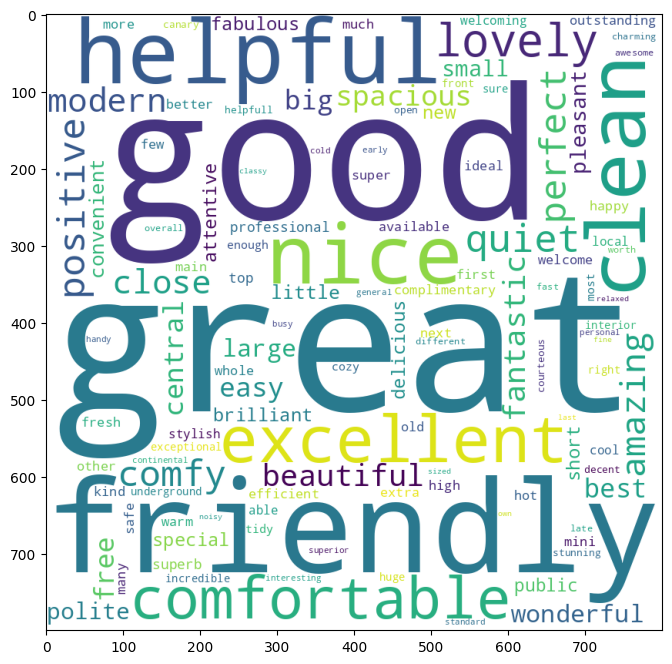

In [124]:
# make word cloud with positive features and negative features
from wordcloud import WordCloud

# make a word cloud for positive features
wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate_from_frequencies(positive_features)
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)

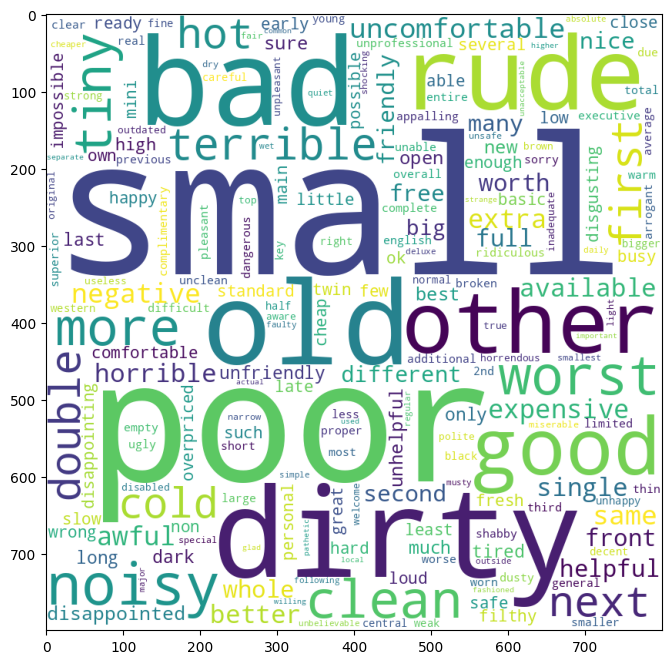

In [125]:
# make a word cloud for positive features
wordcloud = WordCloud(width=800, height=800, background_color='white',
                      min_font_size=10).generate_from_frequencies(negative_features)
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)


## 2) What are the top five features that customers prefer most if they are a solo traveler vs traveling with a group vs on a business trip vs a leisure trip vs traveling as a couple vs a family with young children. You will find these categories in the "Tags" column. There are a few more tags that we don't need. (2 points).

In [126]:
for tag in df['tags'][:10]:
    if 'solo' in tag:
        print(type(tag))

<class 'str'>


In [131]:
# if solo in 'tags' then add to solo_traveler data frame
solo_traveler = df_pos[df_pos['tags'].str.contains('solo')]
couple_traveler = df_pos[df_pos['tags'].str.contains('couple')]
family_traveler = df_pos[df_pos['tags'].str.contains('family')]
business_traveler = df_pos[df_pos['tags'].str.contains('business')]
leisure_traveler = df_pos[df_pos['tags'].str.contains('leisure')]

In [132]:
solo_traveler_sample =  solo_traveler.sample(n=250)
couple_traveler_sample = couple_traveler.sample(n=250)
family_traveler_sample = family_traveler.sample(n=250)
business_traveler_sample = business_traveler.sample(n=250)
leisure_traveler_sample = leisure_traveler.sample(n=250)

In [133]:
print(solo_traveler_sample.shape, couple_traveler_sample.shape, family_traveler_sample.shape, business_traveler_sample.shape, leisure_traveler_sample.shape)

(250, 12) (250, 12) (250, 12) (250, 12) (250, 12)
